# Toronto Bar Location
In this project, we try to find the best location for opening up a new bar.

# 1. Scrapping the Toronto neighborhood data

Load all important libraries

In [1]:
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import regex as re
import requests

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Get all neighborhoods of Toronto. Scrap the data from [Wikipedia](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M):

In [2]:
r = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')
soup = BeautifulSoup(r.content, 'html5lib')

table_contents = []
pattern = re.compile(r'(?<Borough>.+)\((?P<Neighborhood>.+)\)')

table = soup.find('table')
for entry in table.findAll('td'):
    cell = {}
    
    # skip all codes without a designated area
    if entry.span.text == 'Not assigned':
        continue
    
    # get postal code
    cell['PostalCode'] = entry.p.text[:3]
    # borough is in the first line of the span line
    cell['Borough'] = getattr(entry.span.contents[0], 'text', entry.span.contents[0])
    # last get the neighborhoods
    name = pattern.search(entry.span.text)
    cell['Neighborhood'] = re.sub(' /', ',', name['Neighborhood'])

    table_contents.append(cell)
    
df = pd.DataFrame(table_contents)
df

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government
5,M9A,Etobicoke,Islington Avenue
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


In [3]:
df.shape

(103, 3)

# 2. Get latitude and longitude for each neighborhood

Load the coordinates for each neighborhood from a file

In [4]:
!wget -O Geospatial_Coordinates.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/Geospatial_Coordinates.csv

--2021-07-27 12:51:36--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/Geospatial_Coordinates.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2788 (2.7K) [text/csv]
Saving to: ‘Geospatial_Coordinates.csv’

Geospatial_Coordina 100%[===================>]   2.72K  --.-KB/s    in 0s      

2021-07-27 12:51:37 (78.9 MB/s) - ‘Geospatial_Coordinates.csv’ saved [2788/2788]



In [5]:
df_coordinates = pd.read_csv('Geospatial_Coordinates.csv')
df_coordinates.rename({'Postal Code': 'PostalCode'}, axis=1, inplace=True)

In [6]:
df_toronto = df.merge(df_coordinates, on='PostalCode')
df_toronto

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494
5,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242
6,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
7,M3B,North York,Don Mills,43.745906,-79.352188
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937


# 3 Get restaurents and bars for each neighborhood
Set the Foursquare credentials

In [7]:
# The code was removed by Watson Studio for sharing.

#### Create a function to explore all restaurents and bars for the neighborhoods in Toronto

In [8]:
categoryID = {'Restaurent': '4d4b7105d754a06374d81259',
              'Bar': '4bf58dd8d48988d116941735'}

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list = []
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = f'https://api.foursquare.com/v2/venues/explore?&client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&v={VERSION}&ll={lat},{lng}&limit={LIMIT}&radius={radius}&categoryId='
            
        # make the GET request for restaurents and bars
        for category, catID in categoryID.items():
            request = requests.get(url + catID).json()
            try:
                results = request["response"]['groups'][0]['items']
            except:
                print(results)
        
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                category) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Get all bars and restaurents for each neighborhood in Toronto

In [9]:
toronto_venues = getNearbyVenues(names=df_toronto['Neighborhood'],
                                   latitudes=df_toronto['Latitude'],
                                   longitudes=df_toronto['Longitude']
                                  )

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Ontario Provincial Government
Islington Avenue
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Flemingdon Park
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
The Danforth  East
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmount Park
Bayview Village
CFB Toronto
The Danforth West, Ri

#### Count the number of restaurents and bars in each neighborhood

In [10]:
df_toronto_count = df_toronto.copy()

for category in categoryID.keys():
    count = toronto_venues[toronto_venues['Venue Category'] == category].groupby('Neighborhood')
    count = count.count()['Venue Category']
    count.name = category + ' Count'
    df_toronto_count = df_toronto_count.merge(count, on='Neighborhood')
df_toronto_count.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Restaurent Count,Bar Count
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,24,12
1,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,3,1
2,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494,31,9
3,M3B,North York,Don Mills,43.745906,-79.352188,5,1
4,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937,5,2


# 4. Cluster Neighborhoods of Toronto according to the number of restaurents and bars

In [11]:
# import k-means from clustering stage
import numpy as np
from sklearn.cluster import KMeans

Run _k_-means to cluster the neighborhood into 3 clusters for the number of restaurents and the number of pubs

In [12]:
# set number of clusters
kclusters = 3

toronto_clustered = df_toronto_count.copy()

for category in categoryID.keys():
    toronto_grouped_clustering = df_toronto_count[[category +' Count']]
    
    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, init='k-means++', n_init=10, random_state=0).fit(toronto_grouped_clustering)
    
    # sort the labels according to the centers
    idx = np.argsort(np.squeeze(kmeans.cluster_centers_))

    # add the labels to the data frame and replace the numeric labels with 'Low', 'Medium' and 'High'
    toronto_clustered[category + ' Occurance'] = kmeans.labels_
    toronto_clustered[category + ' Occurance'].replace({idx[k]: v for k, v in enumerate(('Low', 'Medium', 'High'))}, inplace=True)
    

# check cluster labels generated for each row in the dataframe
toronto_clustered.groupby(['Restaurent Occurance', 'Bar Occurance']).count()
toronto_clustered.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Restaurent Count,Bar Count,Restaurent Occurance,Bar Occurance
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,24,12,Medium,Low
1,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,3,1,Low,Low
2,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494,31,9,Medium,Low
3,M3B,North York,Don Mills,43.745906,-79.352188,5,1,Low,Low
4,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937,5,2,Low,Low


## Plot the data

In [13]:
import matplotlib.pyplot as plt

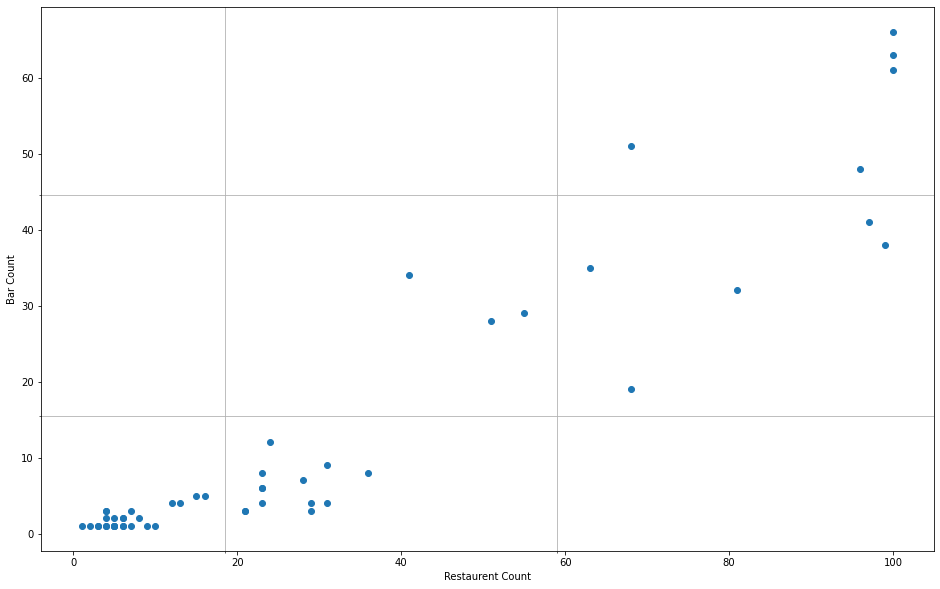

In [14]:
fig, ax = plt.subplots(1, figsize=(16,10))

plt.scatter(x=df_toronto_count['Restaurent Count'], y=df_toronto_count['Bar Count'])

plt.xlabel('Restaurent Count')
plt.ylabel('Bar Count')

# set x ticks
x_max = toronto_clustered.groupby('Restaurent Occurance')['Restaurent Count'].max()[['Low', 'Medium']].to_numpy()
x_min = toronto_clustered.groupby('Restaurent Occurance')['Restaurent Count'].min()[['Medium', 'High']].to_numpy()
x_ticks = (x_max + x_min) / 2

# set y ticks
y_max = toronto_clustered.groupby('Bar Occurance')['Bar Count'].max()[['Low', 'Medium']].to_numpy()
y_min = toronto_clustered.groupby('Bar Occurance')['Bar Count'].min()[['Medium', 'High']].to_numpy()
y_ticks = (y_max + y_min) / 2

ax.set_xticks(x_ticks, minor=True)
ax.set_yticks(y_ticks, minor=True)

plt.grid(which='minor')

In [15]:
toronto_clustered.groupby(['Restaurent Occurance', 'Bar Occurance'])[['Neighborhood']].count()

Neighborhood
Restaurent Occurance Bar Occurance              
High                 High                      5
                     Medium                    5
Low                  Low                      27
Medium               Low                      13
                     Medium                    3

There is no neighborhood with a high amount of restaurents and a low amount of bars.

However, we can chosse a neighborhood with a high amount of restaurents and a medium amount of bars.

There are 5 neighborhoods with this property.

## 4. Create a map with the relevant neighborhoods

In [16]:
!pip3 install folium

/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [17]:
import folium # map rendering library

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

#### Create the map

In [18]:
address = 'Toronto, Canada'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# only show neighborhoods with a large number of restaurents and a medium number of bars
potential_neighborhoods = toronto_clustered[(toronto_clustered['Restaurent Occurance'] == 'High') & (toronto_clustered['Bar Occurance'] == 'Medium')]

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=13)

# set color scheme for the clusters
#x = np.arange(kclusters)
#ys = [i + x + (i*x)**2 for i in range(kclusters)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
for lat, lon, poi, nRest, nBars in potential_neighborhoods[['Latitude', 'Longitude', 'Neighborhood', 'Restaurent Count', 'Bar Count']].values:
    label = folium.Popup(f'{poi}: {nRest} restaurents and {nBars} bars', parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
#        color=rainbow[cluster-1],
        fill=True,
#        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters